In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

TICKER = "USO"
START = "2010-01-01"

df = yf.download(TICKER, start=START, auto_adjust=True, progress=False)
df = yf.download(TICKER, start=START, auto_adjust=True, progress=False)

# Handle MultiIndex columns (e.g., ('Close','USO')) then lowercase
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = [str(c).lower() for c in df.columns]
df = df.dropna()

df = df.dropna()

df.head(), df.tail(), df.shape


(                 close        high         low        open   volume
 Date                                                               
 2010-01-04  322.160004  322.399994  318.959991  320.320007  1426038
 2010-01-05  323.279999  323.600006  319.440002  322.000000  1306275
 2010-01-06  327.760010  329.519989  319.119995  322.559998  2473725
 2010-01-07  325.760010  328.640015  325.440002  326.959991  1252963
 2010-01-08  327.440002  329.359985  323.600006  325.040009  1174188,
                 close       high        low       open   volume
 Date                                                           
 2025-12-26  68.480003  69.760002  68.180000  69.660004  4224500
 2025-12-29  69.610001  70.129997  69.570000  69.849998  2758000
 2025-12-30  69.739998  70.330002  69.650002  70.279999  2324200
 2025-12-31  69.160004  70.260002  68.849998  70.199997  2218700
 2026-01-02  68.699997  68.820000  68.150002  68.430000  2498715,
 (4025, 5))

In [14]:
d = df.copy()

d["ret_1"] = d["close"].pct_change(1)
d["ret_5"] = d["close"].pct_change(5)

for w in [5, 10, 20]:
    d[f"sma_{w}"] = d["close"].rolling(w).mean()
    d[f"px_sma_{w}"] = d["close"] / d[f"sma_{w}"] - 1.0

d["vol_10"] = d["ret_1"].rolling(10).std()
d["vol_20"] = d["ret_1"].rolling(20).std()

# predict next-day return
d["y"] = d["ret_1"].shift(-1)

d = d.dropna()

feature_cols = ["ret_1", "ret_5", "px_sma_5", "px_sma_10", "px_sma_20", "vol_10", "vol_20"]
X = d[feature_cols]
y = d["y"]

d[feature_cols + ["y"]].tail()


,ret_1,ret_5,px_sma_5,px_sma_10,px_sma_20,vol_10,vol_20,y
Date,,,,,,,,
2025-12-24,-0.001423,0.032657,0.016066,0.023995,0.008056,0.018034,0.014839,-0.024501
2025-12-26,-0.024501,0.019199,-0.012517,0.000029,-0.015540,0.018812,0.015637,0.016501
2025-12-29,0.016501,0.023225,-0.000775,0.015345,0.001756,0.019461,0.015737,0.001868
2025-12-30,0.001868,0.000143,0.001062,0.014503,0.004581,0.018766,0.015748,-0.008317
2025-12-31,-0.008317,-0.016216,-0.004004,0.001709,-0.003027,0.016569,0.015628,-0.006651


In [15]:
split = int(len(d) * 0.7)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

test = d.iloc[split:].copy()

(len(X_train), len(X_test), test.index.min(), test.index.max())


(2802,
 1202,
 Timestamp('2021-03-22 00:00:00'),
 Timestamp('2025-12-31 00:00:00'))

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

# Build model
reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

# Fit on training data
reg.fit(X_train, y_train)

# Predict next-day returns on test set
pred = reg.predict(X_test)

# Basic diagnostics
mse = mean_squared_error(y_test, pred)
corr = np.corrcoef(y_test.values, pred)[0, 1]

mse, corr


(0.00044553007912292753, np.float64(-0.053782720845972645))

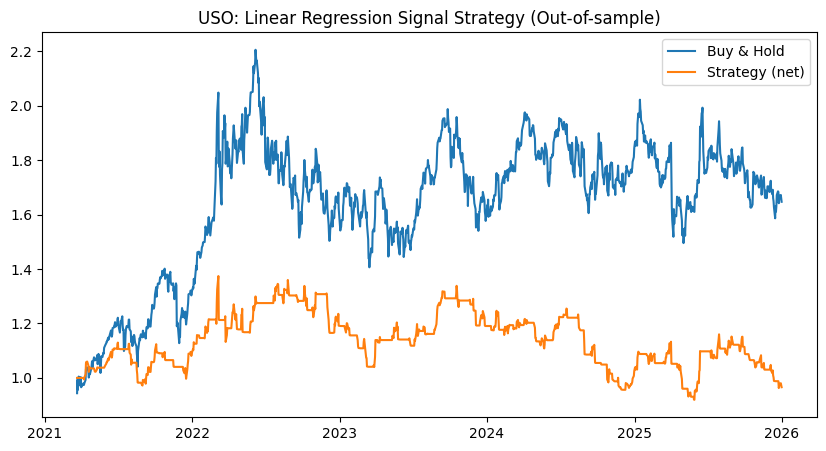

,eq_buyhold,eq_strat
Date,,
2025-12-24,1.641813,0.962866
2025-12-26,1.668904,0.978754
2025-12-29,1.672021,0.980582
2025-12-30,1.658116,0.972427
2025-12-31,1.647087,0.965959


In [17]:
test["pred_ret"] = pred
test["signal"] = (test["pred_ret"] > 0).astype(int)

test["strat_ret_gross"] = test["signal"] * test["y"]

COST_BPS = 10
cost = COST_BPS / 10000.0
test["turnover"] = test["signal"].diff().abs().fillna(0)
test["strat_ret_net"] = test["strat_ret_gross"] - test["turnover"] * cost

test["eq_buyhold"] = (1 + test["y"]).cumprod()
test["eq_strat"] = (1 + test["strat_ret_net"]).cumprod()

plt.figure(figsize=(10,5))
plt.plot(test.index, test["eq_buyhold"], label="Buy & Hold")
plt.plot(test.index, test["eq_strat"], label="Strategy (net)")
plt.title("USO: Linear Regression Signal Strategy (Out-of-sample)")
plt.legend()
plt.show()

test[["eq_buyhold","eq_strat"]].tail()


In [18]:
import json
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# Save equity curve
test[["eq_buyhold", "eq_strat"]].to_csv("results/equity_curve.csv")

# Save metrics
metrics = {
    "mse": float(mse),
    "corr": float(corr),
    "final_eq_buyhold": float(test["eq_buyhold"].iloc[-1]),
    "final_eq_strat": float(test["eq_strat"].iloc[-1]),
    "avg_turnover": float(test["turnover"].mean())
}

with open("results/metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

metrics


{'mse': 0.00044553007912292753,
 'corr': -0.053782720845972645,
 'final_eq_buyhold': 1.6470869924765075,
 'final_eq_strat': 0.9659592383765352,
 'avg_turnover': 0.1605657237936772}